<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Variational Autoencoders for Collaborative Filtering on MovieLens dataset. 

This notebook accompanies the paper "*Variational autoencoders for collaborative filtering*" by Dawen Liang, Rahul G. Krishnan, Matthew D. Hoffman, and Tony Jebara, in The Web Conference (aka WWW) 2018 [[Liang, Dawen, et al,2018]](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o). In this original paper, the public dataset "20M-MovieLens" is used. 

In this notebook, we will show a complete self-contained example of training a Multinomial Variational Autoencoder (described in the original paper) on the public "1M-Movielens" dataset, including data preprocessing, model training and model evaluation.  In the whole notebook we assume that the reader has basic knowledge about VAE [[Kingma et al, 2013]](https://arxiv.org/pdf/1312.6114.pdf). 







# 0 Global Settings and Imports


In [4]:
import sys
sys.path.append("../../")
import os
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
import keras

from reco_utils.common.timer import Timer
from reco_utils.dataset import movielens
from reco_utils.dataset.split_utils import min_rating_filter_pandas
from reco_utils.dataset.python_splitters import numpy_stratified_split
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from reco_utils.common.constants import SEED as DEFAULT_SEED

from reco_utils.recommender.vae.sparse_vae import AffinityMatrix, binarize_matrix
from reco_utils.recommender.vae.multinomial_vae import Mult_VAE

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


System version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
Pandas version: 1.0.5
Tensorflow version: 2.2.0-rc1
Keras version: 2.3.1


Using TensorFlow backend.


In [5]:
# top k items to recommend
TOP_K = 100

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

# Model parameters
HELDOUT_USERS = 600 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 400
BATCH_SIZE = 100

# Path to save the optimal model's weights
WEIGHTS_PATH = "/content/drive/My Drive/Final_Project/Weights/mvae_weights.hdf5" # CHANGE FOR DIFFERENT USER

SEED = 43
# DEFAULT_SEED - Overfits
# 98765 - Overfits

# 1 Multi-VAE algorithm

__Notations__: We use $u \in \{1,\dots,U\}$ to index users and $i \in \{1,\dots,I\}$ to index items. In this work, the user-by-item interaction matrix is the click matrix $\mathbf{X} \in \mathbb{N}^{U\times I}$, which is given as an input to the model. The lower case $\mathbf{x}_u =[X_{u1},\dots,X_{uI}]^\top \in \mathbb{N}^I$ is a bag-of-words vector with the number of clicks for each item from user u. We binarize the click matrix. It is straightforward to extend it to general count data.

__Multi-VAE Model__: For each user $u$, the model starts by sampling a $K$-dimensional latent representation $\mathbf{z}_u$ from a standard Gaussian prior. The latent representation $\mathbf{z}_u$ is transformed via a non-linear function $f_\theta (\cdot) \in \mathbb{R}^I$ to produce a probability distribution over $I$ items $\pi (\mathbf{z}_u)$ from which the click history $\mathbf{x}_u$ is assumed to have been drawn:

$$
\mathbf{z}_u \sim \mathcal{N}(0, \mathbf{I}_K),  \pi(\mathbf{z}_u) = softmax\{f_\theta (\mathbf{z}_u\},\\
\mathbf{x}_u \sim \mathrm{Mult}(N_u, \pi(\mathbf{z}_u))
$$

$\mathbf{z}_u$ needs to be sampled from an approximate posterior   $q_\phi (\mathbf{z}_u | \mathbf{x}_u )$, which is assumed to be a Gaussian. To compute the gradients the reparametrization trick [2] is used and $\mathbf{z}_u$ is calculated by the formula 
$$
\mathbf{z}_u = \mathbf\mu(x_u)+\mathbf\sigma(x_u) \cdot \mathbf\epsilon
$$

where $\mathbf\epsilon \sim \mathcal{N}(0, \mathbf{I})$ and $ \mathbf\mu(x_u), \sigma(x_u)$ are calculated in encoder.


The objective of Multi-VAE (evidence lower-bound, or ELBO) for a single user $u$ is:

$$
\mathcal{L}_u(\theta, \phi) = \mathbb{E}_{q_\phi(z_u | x_u)}[\log p_\theta(x_u | z_u)] - \beta \cdot KL(q_\phi(z_u | x_u) \| p(z_u))
$$

where $q_\phi$ is the approximating variational distribution (inference model/ encoder), and  $p_\theta$ refers to generative model/decoder. The first term is the log-likelohood and the second term is the  Kullback-Leibler divergence term.

Regarding the first term, we use the multinomial log-likelihood formula as proposed in the original paper:

$$
\mathbb \log p_\theta(x_u | z_u)= \sum_i x_{ui} \log \pi_i(z_u) 
$$


Also, we treat $\mathbf KL-divergence$  term as a rerularization term [[Higgins et al, 2016]](https://openreview.net/pdf?id=Sy2fzU9gl), [[Burgess et al, 2018]](https://arxiv.org/pdf/1804.03599.pdf). 


1. When $\mathbf \beta = 1$ corresponds to the original VAE formulation of [[Kingma et al, 2013]](https://arxiv.org/pdf/1312.6114.pdf)

2. Setting $\mathbf \beta > 1$, provides a stronger constraint on the latent bottleneck than in the original VAE formulation. These constraints limit the capacity of $\mathbf z$, which, combined with the pressure to maximise the log likelihood of the training data $\mathbf x$ under the model, should encourage the model to learn the most efficient representation of the data.

3. Setting $\mathbf \beta<1$, we are weakening the influence of the prior constraint. As mentioned in the original paper, this means that the model
is less able to generate novel user histories by ancestral sampling. But ultimately our goal is to make good recommendations, not to maximize likelihood or generate imagined user histories. Treating $\mathbf \beta$ as a free regularization parameter therefore costs us nothing, and,
as we will see, yields significant improvements in performance.

As explained in 3., in our approach we multiply $\mathbf KL $ term with $\mathbf \beta \in [0,1]$. 


__Selecting β:__ As proposed from the original paper, a simple heuristic methodology is used for selecting $\mathbf \beta$. The training process starts with $\mathbf \beta  = 0$, and gradually increase $\mathbf \beta$ to 1. We linearly and slowly anneal the $\mathbf KL$ term over a large number of gradient updates to $\mathbf \theta , \phi $ and record the optimal $\mathbf \beta$ when its performance reaches the peak. Then using this optimal beta we retrain our model using the same annealing procedure but $\mathbf \beta$ stops increasing when it reaches the optimal value found in the previous step.


 This method works well and with the benefit that it does not require training multiple models with different values of $\mathbf \beta$, which can be time-consuming. This idea is based on the paper 
[[Bowman et al, 2015]](https://arxiv.org/pdf/1511.06349.pdf). This methodology is explained in more detail in section (4).

# 2 Keras implementation of Multi-VAE

For the implementation of the model, Keras package is used. 

We will use the MovieLens dataset, which is composed of user-to-item interactions and integer ratings from 1 to 5. We convert MovieLens into binarized clicked matrix ( 1: the user liked this movie , 0: the user did NOT like or did NOT watch/rate this movie), and evaluate based on heldout users data.



# 3 Data Preparation 



### 3.1 Load data and split

We load the data and create train / validation / test splits following strong generalization: 

- We split all unique users into training users and heldout users (i.e. validation and test users)

- By using the lists of these users, we obtain corresponding training data and heldout data, which are converted to click matrices

- We train models using the entire click history of the training users. 

- To evaluate, we take part of the click history from heldout (validation and test) data to learn the necessary user-level representations for the model and then compute metrics by looking at how well the model ranks the rest of the unseen click history from the heldout data

#### 3.1.1 Load data

In [6]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

df.head()

100%|██████████| 5.78k/5.78k [00:00<00:00, 31.6kKB/s]


,userID,itemID,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291


In [7]:
df.shape

(1000209, 4)


We have to make sure:
 - each user clicked at least 5 movies
 - each movie was clicked at least once

In [8]:
# Keep users who clicked on at least 5 movies
df = min_rating_filter_pandas(df, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [9]:
# Count the number of unique users and items in the original dataset
n_users = df.userID.unique().shape[0]
n_items = df.itemID.unique().shape[0]

# Compute sparsity of the original dataset
sparsity = float(df.shape[0]) / float(n_users * n_items) * 100

print("In the original dataset, there are %d rating events from %d users and %d movies (sparsity: %.3f%%)" % 
      (df.shape[0], n_users, n_items, sparsity))

In the original dataset, there are 1000209 rating events from 6040 users and 3706 movies (sparsity: 4.468%)


#### 3.1.2 Split data

For data slitting we use:
- 600 (~ 10%) users in validation set 
- 600 (~ 10%) users in testing set 
- the rest of them (~ 80%) in training set


Since the model is trained using the click history of the training users, we have to make sure that the movies that exist in the validation and test sets are the movies that exist in the train set. In other words, validation and test set should not contain movies that do not exist in the train set.


In [10]:
unique_users = sorted(df.userID.unique())
np.random.seed(SEED)
unique_users = np.random.permutation(unique_users)

In [11]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - HELDOUT_USERS * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - HELDOUT_USERS * 2) : (n_users - HELDOUT_USERS)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - HELDOUT_USERS):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 6040

Number of training users: 4840

Number of validation users: 600

Number of test users: 600


In [12]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

# train_set/val_set/test_set contain user - movie interactions with rating 4 or 5

Number of training observations:  803148

Number of validation observations:  100104

Number of test observations:  96957


In [13]:
# Obtain list of unique movies used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique movies that rated in training set", unique_train_items.size)

Number of unique movies that rated in training set 3689


In [14]:
# For validation set keep only movies that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  100094

Number of test observations after filtering:  96948


## 3.2 Click matrix generation 

From section 3.1 we end up with 3 datasets train_set, val_set and test_set.  For our model we need to give a click matrix as an input that contains only 0-s and 1-s, where each row represents a user and each column represents a movie. 
So, the click matrix contains the preferences of the user, marking each cell with 0 when the user did not enjoy (ratings below 3.5) or did not watch a movie and with 1 when the user enjoyed a movie (ratings above 3.5). It should be noted that in the original approach, it is recommended to filter out movies with ratings below 3.5. In order to keep full historicity per user we do not apply this filtering.

The training set will be a click matrix containing full historicity of all training users. However, the test set and validation set should be splitted into train and test parts. As a result, we get 4 datasets:
- val_data_tr
- val_data_te
- test_data_tr
- test_data_te

_'val_data_tr'_ contains 75% of the the preferred movies (movies marked as 1 in the click matrix) per user.
The rest 25% of the preffered movies are contained into the _'val_data_te'_. The same splitting is followed for test set. 

The _'val_data_tr'_ is given as an input for our model at the end of each epoch. The result of the model is a _'reconstructed_val_data_tr'_, which contains the movies recommended for each user by the model. In order to evaluate the performance of the model, at the end of each epoch, we compare the _'reconstructed_val_data_tr'_ (predicted recommendations by the model) with the _'val_data_te'_ (true movie preferences of each user) using NDCG@k metric. 

For the final evaluation of the model the _'test_data_tr'_ and _'test_data_te'_ are being used. As we described before, the _'test_data_tr'_ is given as an input for the model and returns the _'reconstructed_test_data_tr'_ dataset with the recommendations made by the model. Then, the _'reconstructed_test_data_tr'_ is compared with _'test_data_te'_ through different metrics:
- MAP
- NDCG@k
- Recall@k
- Precision@k






In [15]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(DF=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(DF=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(DF=test_set, items_list=unique_train_items)

In [16]:
# Obtain the sparse matrix for train, validation and test sets
train_data = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data = am_test.gen_affinity_matrix()
print(test_data.shape)

(4840, 3689)
(600, 3689)
(600, 3689)


In [17]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [18]:
# Binarize train, validation and test data
train_data = binarize_matrix(data=train_data, threshold=3.5)
val_data = binarize_matrix(data=val_data, threshold=3.5)
test_data = binarize_matrix(data=test_data, threshold=3.5)

In [19]:
# Binarize validation data: training part  
val_data_tr = binarize_matrix(data=val_data_tr, threshold=3.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ = val_data_te.copy()
val_data_te = binarize_matrix(data=val_data_te, threshold=3.5)

In [20]:
# Binarize test data: training part 
test_data_tr = binarize_matrix(data=test_data_tr, threshold=3.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ = test_data_te.copy()
test_data_te = binarize_matrix(data=test_data_te, threshold=3.5)

In [21]:
# Just checking
print(np.sum(val_data))
print(np.sum(val_data_tr))
print(np.sum(val_data_te))

57440.0
43094.0
14346.0


In [22]:
# Just checking
print(np.sum(test_data))
print(np.sum(test_data_tr))
print(np.sum(test_data_te))

56765.0
42652.0
14113.0


# 4 Train Multi-VAE using Keras


__Model Architecture:__

For "MovieLens-1M dataset", we set both the generative function $f_\theta(\cdot)$ and the inference model $g_\phi(\cdot)$ to be 3-layer multilayer perceptron (MLP) with symmetrical architecture.
The generative function is a [70 -> 200 -> n_items] MLP, which means the inference function is a [n_items -> 200 -> 70] MLP. Thus the overall architecture for the Multi-VAE is [n_items -> 200 -> 70 -> 200 -> n_items]. 
Also, Dropout is applied both in encoder and decoder to avoid overfitting. 


Note that this architecture, illustrated in the graph below, is the one that resulted optimal results after doing hyperparameter tuning.



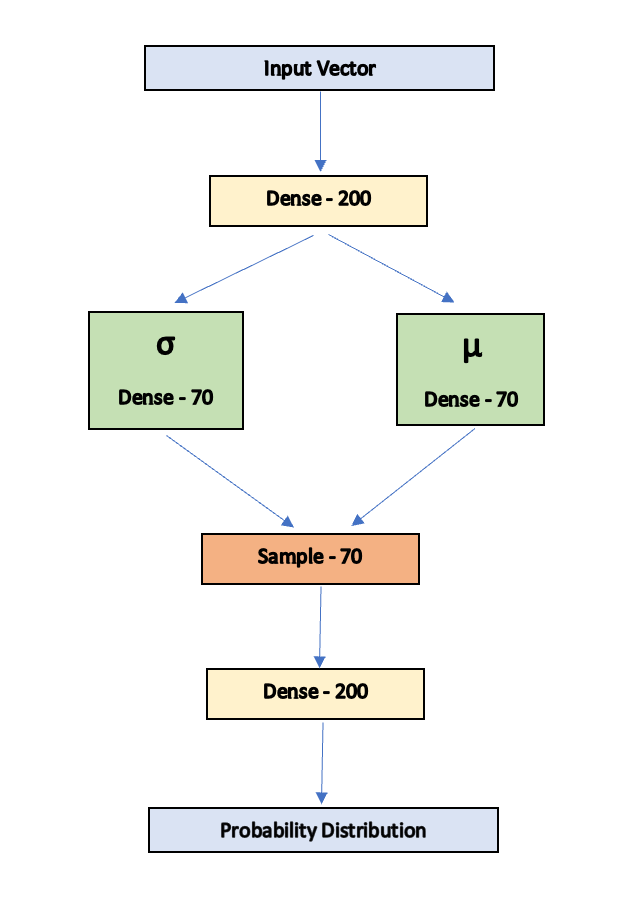

__Model Training:__ 

One of the most interesting parts of the original paper is the tuning of $\mathbf \beta$ using annealing. As it is described in section 1, $\mathbf KL- divergence$ is handled as regularization term. $\mathbf KL-divergence$ term is linearly annealed by increasing $\mathbf \beta$ from 0 to 1 slowly over a large number of training steps. From the original paper is proposed that __$\mathbf \beta$ should reach $\mathbf \beta = 1$ at around the 80% of the epochs__ and then $\mathbf \beta$ remains stable at the value of 1. Then optimal beta is found based on the peak value of NDCG@k of the validation set.


After finding the optimal beta, we retrain the model with the same annealing but we stop the increase of $\mathbf \beta$ after reaching the value of optimal $\mathbf \beta$ found in the previous step. Alternatively, we can say that we anneal $\mathbf \beta$ until it reaches the anneal_ap (anneal cap = optimal $\mathbf \beta$). 





## 4.1 Multi-VAE without annealing  (initial approach) 

Firstly, we train Multi-VAE model using constant $\mathbf \beta$= 1.


In [24]:
model_without_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=0,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=False,
                                beta=1.0
                                )

In [25]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                             x_valid=val_data, 
                             x_val_tr=val_data_tr, 
                             x_val_te=val_data_te_,  # use val_data_te_, with the original ratings 
                             mapper=am_val
                             )
print("Took {} seconds for training.".format(t))

Took 1002.1368 seconds for training.


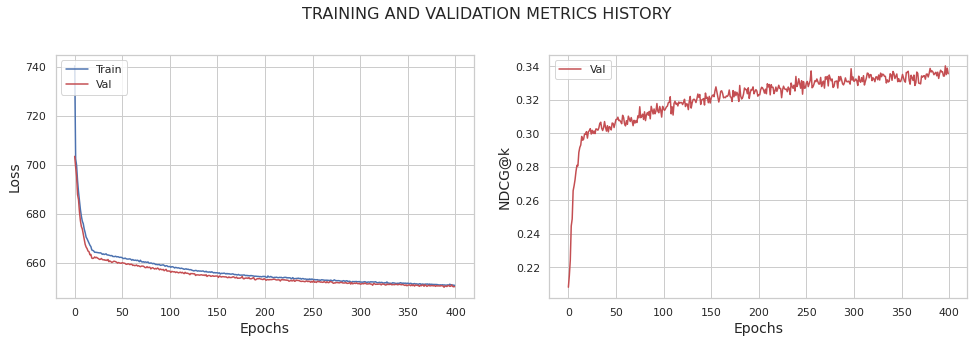

In [26]:
model_without_anneal.display_metrics()

In [27]:
ndcg_val_without_anneal = model_without_anneal.ndcg_per_epoch()

#### Prediction and Evaluation of Multi-VAE model using constant 𝛽 = 1.

Evaluate with recommending 10 items.

In [28]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_1,
      "NDCG@10:\t%f" % eval_ndcg_1,
      "Precision@10:\t%f" % eval_precision_1,
      "Recall@10: \t%f" % eval_recall_1, sep='\n')

Took 1.1082 seconds for prediction.
MAP@10:		0.054803
NDCG@10:	0.310228
Precision@10:	0.277333
Recall@10: 	0.096403


Evaluate with recommending 100 items.

In [29]:
# Use k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=TOP_K,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_2 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_ndcg_2 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_precision_2 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_recall_2 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)

print("MAP@100:\t%f" % eval_map_2,
      "NDCG@100:\t%f" % eval_ndcg_2,
      "Precision@100:\t%f" % eval_precision_2,
      "Recall@100: \t%f" % eval_recall_2, sep='\n')

Took 0.5384 seconds for prediction.
MAP@100:	0.116828
NDCG@100:	0.326859
Precision@100:	0.134233
Recall@100: 	0.396893


## 4.2 Multi-VAE with annealing 
We are going to use annealing procedure for finding the optimal $\mathbf \beta$.

Now, in order to find the optimal β, we train our model using annealing with anneal_cap equal 1.0.




In [30]:
model_with_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                             original_dim=train_data.shape[1], # Number of unique items in the training set
                             intermediate_dim=INTERMEDIATE_DIM, 
                             latent_dim=LATENT_DIM, 
                             n_epochs=EPOCHS, 
                             batch_size=BATCH_SIZE, 
                             k=TOP_K,
                             verbose=0,
                             seed=SEED,
                             save_path=WEIGHTS_PATH,
                             drop_encoder=0.5,
                             drop_decoder=0.5,
                             annealing=True,
                             anneal_cap=1.0,       
                             )

In [31]:
with Timer() as t:
    model_with_anneal.fit(x_train=train_data, 
                          x_valid=val_data, 
                          x_val_tr=val_data_tr, 
                          x_val_te=val_data_te, 
                          mapper=am_val
                          )
print("Took {} seconds for training.".format(t))

Took 995.7834 seconds for training.


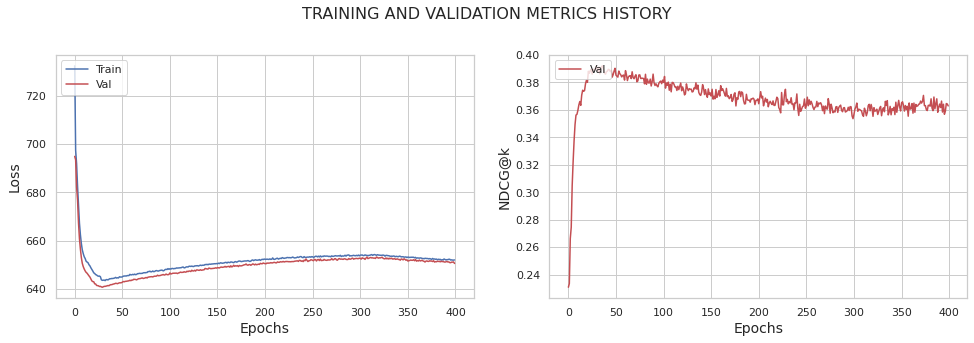

In [32]:
model_with_anneal.display_metrics()

In [33]:
ndcg_val_with_anneal = model_with_anneal.ndcg_per_epoch()

Using the optimal beta as anneal cap , we retrain our model. 

When NDCG@k of validation set reach a peak, the weights of the model are saved. Using this model we evaluate the test set. 

In [34]:
# Get optimal beta 
optimal_beta = model_with_anneal.get_optimal_beta()
print( "The optimal beta is: ", optimal_beta)

The optimal beta is:  0.115625


In [35]:
model_optimal_beta = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                              original_dim=train_data.shape[1], # Number of unique items in the training set
                              intermediate_dim=INTERMEDIATE_DIM,
                              latent_dim=LATENT_DIM,
                              n_epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              k=TOP_K,
                              verbose=0,
                              seed=SEED,
                              save_path=WEIGHTS_PATH,
                              drop_encoder=0.5,
                              drop_decoder=0.5,
                              annealing=True,
                              anneal_cap=optimal_beta,  
                              )

In [36]:
with Timer() as t:
    model_optimal_beta.fit(x_train=train_data, 
                           x_valid=val_data, 
                           x_val_tr=val_data_tr, 
                           x_val_te=val_data_te, 
                           mapper=am_val
                           )
print("Took {} seconds for training.".format(t))

Took 1000.9434 seconds for training.


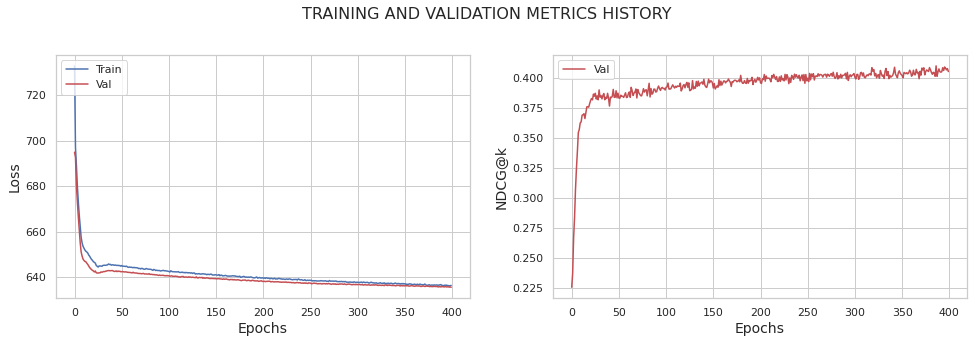

In [37]:
model_optimal_beta.display_metrics()

In [38]:
ndcg_val_optimal_beta = model_optimal_beta.ndcg_per_epoch()

#### Prediction and Evaluation of Standard-VAE model using the optimal 𝛽 with annealing.

Evaluate with recommending 10 items.

In [39]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=10,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_3 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_3 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_3 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_3 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_3,
      "NDCG@10:\t%f" % eval_ndcg_3,
      "Precision@10:\t%f" % eval_precision_3,
      "Recall@10: \t%f" % eval_recall_3, sep='\n')

Took 0.9100 seconds for prediction.
MAP@10:		0.069247
NDCG@10:	0.349988
Precision@10:	0.313667
Recall@10: 	0.117921


Evaluate with recommending 100 items.

In [40]:
# Use k = TOP_K
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_optimal_beta.recommend_k_items(x=test_data_tr,
                                                  k=TOP_K,
                                                  remove_seen=True
                                                  )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_4 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_ndcg_4 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_precision_4 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_recall_4 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)

print("MAP@100:\t%f" % eval_map_4,
      "NDCG@100:\t%f" % eval_ndcg_4,
      "Precision@100:\t%f" % eval_precision_4,
      "Recall@100: \t%f" % eval_recall_4, sep='\n')

Took 0.5446 seconds for prediction.
MAP@100:	0.143796
NDCG@100:	0.373622
Precision@100:	0.145250
Recall@100: 	0.450108


For comparison reasons, we train a Mult_VAE without using annealing , using a constant value of β=1.

# 5 Conclusion 

Through this notebook is proven that Mult-VAE has competitive performance. 


From the above plot, we can see that the model using annealing outperforms the model with annealing. Specifically, the results of evaluating the test set, for the the 2 different approaches, are:


| Model | NDCG@100 | Recall@100 |  Precision@100 |NDCG@10 | Recall@10 |  Precision@10 |
| --- | --- | --- | --- | --- | --- | --- |
| Mult-VAE (wihtout annealing, β=1)| 0.326 | 0.396 | 0.134 | 0.310 | 0.096 | 0.277 |
| Mult-VAE (with annealing, optimal β)| 0.373 | 0.450 | 0.145 | 0.349 | 0.117 | 0.313 |


This annealing procedure is used as an efficient way to tune the parameter $\mathbf \beta$. Otherwise, training multiple models using different values of $\mathbf \beta$ can be really time consuming. 



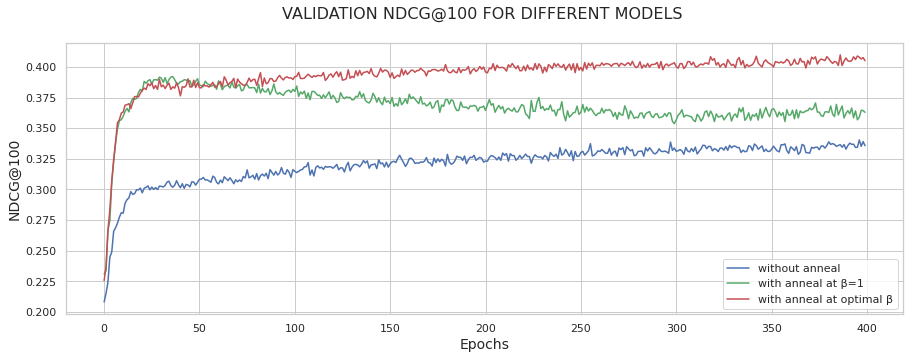

In [41]:
# Plot setup
plt.figure(figsize=(15, 5))
sns.set(style='whitegrid')

# Plot NDCG@k of validation sets for three models
plt.plot(ndcg_val_without_anneal, color='b', linestyle='-', label='without anneal')
plt.plot(ndcg_val_with_anneal, color='g', linestyle='-', label='with anneal at β=1')
plt.plot(ndcg_val_optimal_beta, color='r', linestyle='-', label='with anneal at optimal β')

# Add plot title and axis names
plt.title('VALIDATION NDCG@100 FOR DIFFERENT MODELS \n', size=16)
plt.xlabel('Epochs', size=14)
plt.ylabel('NDCG@100', size=14)
plt.legend(loc='lower right')

plt.show()

Both for choosing the optimal $\mathbf \beta$ and the optimal model weights we use the NDCG@100 evaluation metric in the validation set (section [4], Paragraph: __Model Training__). But, why is NDCG@100 chosen?


For evaluating the model, we give as input the val_data_tr and we receive as a output the reconstructed val_data_tr. Then we keep the top K recommendation. In order to check if those recommendations are correct we have to keep the top K movies in the val_data_te, after applying sorting. 

Given that the val_data_te is a click matrix, sorting the val_data_te makes sense only if within the top K movies exists both 0 and 1. In the histogram presented below we can see that most users have less than 100 clicked movies. So, the use of the NDCG@100 is the metric that can help us evaluate efficiently our model.





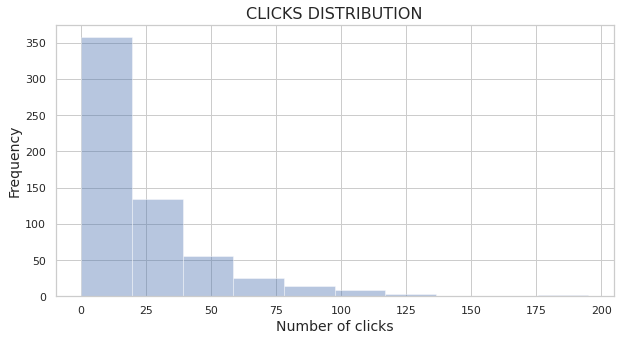

In [42]:
tmp = pd.DataFrame(val_data_te)
tmp = pd.DataFrame(tmp.sum(axis=1))

# Plot setup
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid')

sns.distplot(tmp[0], bins=10, kde=False)
plt.title('CLICKS DISTRIBUTION', size=16)
plt.xlabel("Number of clicks", size=14)
plt.ylabel("Frequency", size=14)
plt.show()


Last but not least, it is worth mentioning that for different shuffling of input data, the model may need again hyperparameter tuning.  

In [ ]:
# Record results with papermill for tests
#pm.record("map", eval_map_1)
#pm.record("ndcg", eval_ndcg_1)
#pm.record("precision", eval_precision_1)
#pm.record("recall", eval_recall_1)

#pm.record("map", eval_map_3)
#pm.record("ndcg", eval_ndcg_3)
#pm.record("precision", eval_precision_3)
#pm.record("recall", eval_recall_3)

# 6 References

[Liang, Dawen, et al, 2018] [Liang, Dawen, et al. "Variational autoencoders for collaborative filtering." Proceedings of the 2018 World Wide Web Conference. 2018.](https://dl.acm.org/doi/pdf/10.1145/3178876.3186150?casa_token=zul5haircsAAAAAA:iIKn7y-xWwSeqaP-MmmyUaJoJuNZX9Fx1aXeFJwkwtMpVDCrPMW3kZjuYo1LKhSuMeUMNf1mbP2o) 

[Kingma et al, 2013] [Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes."  (2013).](https://arxiv.org/pdf/1312.6114.pdf)

[Burgess et al, 2018] [Burgess, Christopher P., et al. "Understanding disentangling in $\beta $-VAE." (2018)](https://arxiv.org/pdf/1804.03599.pdf)

[Higgins et al, 2016] [Higgins, Irina, et al. "beta-vae: Learning basic visual concepts with a constrained variational framework." (2016).](https://openreview.net/pdf?id=Sy2fzU9gl)


[Bowman et al, 2015] [Samuel R. Bowman, Luke Vilnis, Oriol Vinyals, Andrew M. Dai, Rafal Jozefowicz,
and Samy Bengio. 2015. Generating sentences from a continuous space. (2015).](https://arxiv.org/pdf/1511.06349.pdf)
